In [0]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.stattools as st

import scipy as sp

In [0]:
# SparkSession
spark = SparkSession.builder.getOrCreate()

### Functions

In [0]:
def ITS_model_naive(data: pd.DataFrame,
                    formula: str) -> pd.DataFrame:
    '''
    Main focus: Implementing naive (OLS) regression model, assessing coefficients, significance, and checking CLRM assumptions
    Approach: Utilize joblib's Parallel and delayed functions to concurrently process each location's time series data, applying OLS regression, and aggregate the key statistical metrics into a DataFrame
    '''
    # Create an empty DataFrame to store all statistical metrics for all location_id 
    results_df = pd.DataFrame()

    # Define inner function to apply OLS regression and get statistical metrics
    def process_location(location_id: str,
                         group: pd.DataFrame) -> pd.DataFrame:
        
        # Define and fit naive OLS regression model
        naive = smf.ols(formula = formula, data=group).fit()
        
        # Create statistical metrics dataframe
        results = pd.DataFrame([{
            'location_id': location_id,
            'coef': naive.params, # Linear coeff (aka betas) that min least square criterion
            'pvalues': naive.pvalues, # two-tailed p-values for t-stats of params
            #'Durbin_Watson': st.durbin_watson(naive.resid), # Durbin-Watson statistic: [0;4] --> if ~0 then positive serial correlation (autocorrelation), otherwise (~4) then negative serial correlation (autocorrelation)
            'BreuschGodfrey': dg.acorr_breusch_godfrey(res=naive, nlags=7)[3], # Breusch-Godfrey test (testing serial correlation): check persistance over weeks (daily observations)
            'HeteroscedasticityARCH': dg.het_arch(resid=naive.resid, nlags=7)[3], # Heteroscedasticity ARCH test (testing heteroscedasticity): check persistence over weeks (daily observations)
            'JarqueBera': st.jarque_bera(naive.resid)[1] # Jarque-Bera test (testing normality distribution of errors)
        }])
        
        # Return statistical metrics for current location
        return results
    
    # Parallelize the processing of each location
    processed_results = Parallel(n_jobs=-1)(
        delayed(process_location)(location_id, group)
        for location_id, group in data.groupby('location_id')
    )
    
    # Concatenate results from parallel processing
    results_df = pd.concat(processed_results, ignore_index=True)
    
    # Return the statistical metrics for each locaion_id
    return results_df

In [0]:
def add_new_col(d_temp: pd.DataFrame) -> None:
    '''
    Main focus: Incorporating new columns related to interventions and days
    Approach: Utilizing the date and intervention columns, create intervention2 to indicate intervention occurrences, days to represent the cumulative days, and intervention_day to accumulate intervention days
    '''
    # Return existing DataFrame with three new col
    return d_temp.assign(intervention2 = lambda d: (d['date'] >= d['intervention']).astype(int),
                         days = np.arange(len(d_temp)) +1,
                         intervention_day = lambda d: d['intervention2'].cumsum())

### Interrupted Time Series model

In [0]:
# Load jersey data
table_name = 'eliqdatalake.playground.jersey_data'
query = f"SELECT * FROM {table_name}"
data = spark.sql(query).toPandas().sort_values(['location_id', 'date']).reset_index(drop=True)

In [0]:
# TODO: Go back to preprocessing phase and add condition to check the presence of zero-values --> ex 1840990 ==> DONE
d = [loc_id for loc_id, group in data.groupby('location_id') if (group['energy']==0).sum()/len(group) >= 0.2]
for location_id in d:
    data.drop(data.query(f'location_id=={location_id}').index, inplace=True)
data.reset_index(drop=True, inplace=True)

#### Naive (OLS) linear regression model

**Causal Inference problem**: Figuring out the effect of the usage of Eliq’s solution on energy consumption - Do Eliq’s energy management solutions cause changes (decrease) in energy consumptions?

**Goal**: Eliq's energy management solutions decrease energy consumption.

**Model**: (Naive OLS) linear regression model

**Estimation method**: Ordinary Least Squares (OLS) --> Minimize the sum of squared errors by using residual sum of squares (RSS)

**Regression formula**: Look at the The event book, chapter 17 (https://theeffectbook.net/ch-EventStudies.html#event-studies-with-regression)

**Requirement before fitting the model** : stationarity

**Statistical metrics**: Checking requirements after fitting the model, ie the goodness of results:
* *Breusch-Godfrey test*: testing for serial correlation (autocorrelation); hypothesis test:\
H_0: No correlation in the errors of the model\
H_1: Correlation in the errors of the model\
NB. If rejecting H_0, then bad idea to use OLS as estimation method because it violates the CLRM assumption
* *Heteroscedasticity ARCH test*: testing for homoscedasticity (ie presence of volatility); hypothesis test:\
H_0: No dependence in the variance of the error at time t with the error at time t-1, t-2,...,t-n (homoscedasticity)\
H_1: Dependence in the variance of the error at time t with the error at time t-1, t-2,...,t-n (heteroscedasticity)\
NB. If rejecting H_0, then there are two solutions (1) GLS (theoretical solution for panel data) and (2) GARCH model (where heteroscedasticity arises in the presence of volatility in the shock)
* *Jarque-Bera test*: testing normality distributions of errors; hypothesis test:\
H_0: Normality\
H_1: Non-normality

In [0]:
data = data.groupby('location_id').apply(add_new_col)
data

/root/.ipykernel/1210/command-2980240222357266-3983560446:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby('location_id').apply(add_new_col)


,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed,brightness_s2s,energyprice,energyprice_percChange,energyprice_change,energy_diff,temp_diff,cloudcover_diff,humidity_diff,precip_diff,windspeed_diff,brightness_s2s_diff,energyprice_diff,energyprice_percChange_diff,energyprice_change_diff,intervention2,days,intervention_day
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2,0.41,43.71,0.000,0.00,9429.0,18.6,17.0,86.0,0.0,12.2,0.41,43.71,0.000,0.00,0,1,0
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5,0.41,43.71,0.000,0.00,744.0,0.3,-6.0,-2.0,0.0,0.3,0.00,0.00,0.000,0.00,0,2,0
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5,0.40,43.71,0.000,0.00,-2241.0,-1.8,31.0,9.0,0.0,1.0,-0.01,0.00,0.000,0.00,0,3,0
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0,0.40,43.71,1.580,0.68,-31.0,-1.8,-4.0,-9.0,0.1,14.5,0.00,0.00,1.580,0.68,0,4,0
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4,0.40,42.96,-1.716,-0.75,737.0,-2.8,-2.0,-7.0,0.1,12.4,0.00,-0.75,-3.296,-1.43,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3663036,6404010,2023-04-22,2022-04-26,15038.0,10.3,52.0,86.0,0.0,18.0,0.52,98.76,0.000,0.00,7803.0,1.4,14.0,9.0,0.0,3.6,0.00,0.00,0.373,0.37,1,727,362
3663037,6404010,2023-04-23,2022-04-26,19145.0,10.1,69.0,92.0,0.0,23.4,0.52,98.76,0.000,0.00,4107.0,-0.2,17.0,6.0,0.0,5.4,0.00,0.00,0.000,0.00,1,728,363
3663038,6404010,2023-04-24,2022-04-26,8908.0,9.9,47.0,85.0,0.0,22.8,0.53,97.84,-0.932,-0.92,-10237.0,-0.2,-22.0,-7.0,0.0,-0.6,0.01,-0.92,-0.932,-0.92,1,729,364
3663039,6404010,2023-04-25,2022-04-26,9144.0,8.8,46.0,75.0,0.0,21.2,0.53,97.92,0.082,0.08,236.0,-1.1,-1.0,-10.0,0.0,-1.6,0.00,0.08,1.014,1.00,1,730,365


In [0]:
data.drop(['date',
         'intervention',
         'energy',
         'temp',
         'cloudcover',
         'humidity',
         'precip',
         'windspeed',
         'brightness_s2s',
         'energyprice',
         'energyprice_percChange',
         'energyprice_change',
         'temp_diff',
         'cloudcover_diff',
         'humidity_diff',
         'precip_diff',
         'windspeed_diff',
         'brightness_s2s_diff',
         'energyprice_diff',
         'energyprice_percChange_diff',
         'energyprice_change_diff'], axis=1, inplace=True)
data

,location_id,energy_diff,intervention2,days,intervention_day
0,1420037,9429.0,0,1,0
1,1420037,744.0,0,2,0
2,1420037,-2241.0,0,3,0
3,1420037,-31.0,0,4,0
4,1420037,737.0,0,5,0
...,...,...,...,...,...
3663036,6404010,7803.0,1,727,362
3663037,6404010,4107.0,1,728,363
3663038,6404010,-10237.0,1,729,364
3663039,6404010,236.0,1,730,365


In [0]:
#data = data.reset_index(drop=True)

In [0]:
new_res = ITS_model_naive(data, formula='energy_diff ~ intervention2 + days + intervention_day')
new_res

,location_id,coef,pvalues,BreuschGodfrey,HeteroscedasticityARCH,JarqueBera
0,1420037,Intercept 76.187701 intervention2 ...,Intercept 0.756855 intervention2 ...,3.541880e-62,3.542960e-17,1.798166e-08
1,1420043,Intercept 109.839591 intervention2 ...,Intercept 0.797421 intervention2 ...,1.541391e-61,7.218846e-14,4.924716e-07
2,1420059,Intercept 161.392835 intervention2 ...,Intercept 0.575253 intervention2 ...,7.651353e-64,3.554185e-08,4.045508e-03
3,1420066,Intercept 120.199037 intervention2 ...,Intercept 0.584865 intervention2 ...,1.853441e-60,4.472069e-20,2.476077e-129
4,1420072,Intercept 302.617296 intervention2 ...,Intercept 0.572943 intervention2 ...,3.477909e-15,3.799656e-13,7.851131e-23
...,...,...,...,...,...,...
5006,5481719,Intercept 7.963326 intervention2 ...,Intercept 0.728519 intervention2 ...,3.857263e-71,9.798466e-85,0.000000e+00
5007,5651511,Intercept 62.837769 intervention2 ...,Intercept 0.836161 intervention2 ...,8.325333e-44,6.661834e-03,3.521022e-48
5008,6061367,Intercept 257.401114 intervention2 ...,Intercept 0.617958 intervention2 ...,8.638287e-42,2.141357e-21,2.078568e-186
5009,6377801,Intercept 193.052807 intervention2 ...,Intercept 0.784180 intervention2 ...,3.363103e-66,2.272012e-14,5.063999e-08


In [0]:
# Check goodness of results and statistical metrics for naive OLS models
for location_id, group in new_res.groupby('location_id'):
    # Get coefficient for intervention2 --> estimates of energy consumption effect in percentage
    coeff = round(group['coef'].iloc[0]['intervention2'], 2)
    # Get pvalues for intervention2 --> testing statistical significance of coeff
    pvalue = round(group['pvalues'].iloc[0]['intervention2'], 2)
    # Get p-value of Breusch-Godfrey test
    bg = round(group['BreuschGodfrey'].iloc[0], 2)
    # Get p-value of Heteroscedasticity ARCH test
    h = round(group['HeteroscedasticityARCH'].iloc[0], 2)
    # Get p-value of Jarque-Bera test
    jb = round(group['JarqueBera'].iloc[0], 2)
    # Checking condition for hypothesis tests
    if bg > 0.05 or h > 0.05 or jb > 0.05:
        if pvalue < 0.05:
            print(f"{location_id}: coefficient for intervention2 is {coeff}, its pvalue is {pvalue}, Breusch-Godfrey is {bg}, Heteroscedasticity ARCH is {h} and Jarque-Bera is {jb}")

**Conclusion naive OLS linear regression model**

After testing all locations for serial correlation, heteroscedasticity, and normality distributions of errors, it is evident that OLS is not an appropriate estimation method in our case. The reasons are as follows:
* *Breusch-Godfrey test*: For all the locations, we reject H_0, indicating the presence of serial correlation (autocorrelation) in the errors of the models. This violates CLRM assumption (3): Cov(ui, uj) = 0 
* *Heteroscedasticity ARCH test*: For all locations, we rejet H_0, suggesting dependence in the variance of the error at time t with the error at time t-1, t-2,..., t-n (heteroscedasticity). This violates CLRM (2): Var(ut) = σ^2 < ∞
* *Jarque-Bera test*: For most of the locations, we reject H_0, indicating that the residuals are not normally distributed, thus are still not known. This violates CLRM (5): ut ∼ N (0, σ^2)

*Consequences* of these violations are that (i) the coefficient estimates are wrong, (ii) the associated standard errors are wrong and (iii) the distribution that we assumed for the test statistics will be inappropriate.

*Potential solutions*:
1. Given serial correlation and heteroscedasticity, two potential solutions are:\
  a. GLS (Generalised least squares) --> Only theoretical solution\
  b. GARCH model --> Primarily designed for financial time series data, it captures autocorrelation and heteroscedasticity in residuals. However, it is not tested due to being outside the project scope
2. Bayesian Structural Time Series --> A paradigm shift employing a Bayesian estimation method

Why not try ARIMA? 
* ARIMA model only consider time-varying mean and constant conditional variance, thus failing to capture time-varying volatility. In other words, it cannot model heteroscedasticity.

In summary, OLS as estimation method for naive linear regression model is wrong since it violates CLRM assumptions; attempting to test predicitons using such model would be misguided, given its inherent violantions of the assumptions. Both ARIMA and GARCH models employ MLE as estimation method but they are not suitable for our task. The former cannot model heteroscedasticity while the latter falls beyond the project scope. Thus, the shift from (naive) linear models to Bayesian structural framework is justified by not only potential poor prediction resuts but mainly because the former fails to support its underlying assumptions.

#### GARCH

In [0]:
def ITS_model_garch(data: pd.DataFrame,
                     y: str) -> pd.DataFrame:

    def process_location(location_id: str,
                         group: pd.DataFrame) -> pd.DataFrame:
        garch = arch_model(y=group[y], vol='GARCH', p=1, q=1).fit()
        std_resid = garch.resid / garch.conditional_volatility
        results = pd.DataFrame([{
            'location_id': location_id,
            'coef': garch.params,
            'pvalues': garch.pvalues,
            'Heteroskedasticity_pvalues': dg.het_arch(std_resid)[3],
            'JarqueBera': jarque_bera(std_resid)[1]
        }])
        return results

    results_df = pd.DataFrame()
    processed_results = Parallel(n_jobs=-1)(
        delayed(process_location)(location_id, group)
        for location_id, group in data.groupby('location_id')
    )
    results_df = pd.concat(processed_results, ignore_index=True)
    return results_df

In [0]:
#new_res = ITS_model_garch(data, y='energy_diff')
#new_res

In [0]:
# Check goodness of results of garch models -->Heteroskedasticity test and normality shows that 
for loc_id, group in new_res.groupby('location_id'):
    # Get coeff of omega
    omega = group['coef'].iloc[0]['omega']
    alpha = group['coef'].iloc[0]['alpha[1]']
    beta = group['coef'].iloc[0]['beta[1]']
    if omega > 0 and alpha >= 0 and beta > 0 and (alpha+beta)<1:
        H = group['Heteroskedasticity_pvalues'].iloc[0]
        JB = group['JarqueBera'].iloc[0]
        if H > 0.05 and JB > 0.05:
            print(f"{loc_id}: H {H}, JB {JB} ")

1420138: H 0.44093834894014117, JB 0.06486022757799242 
1420250: H 0.32020135094893215, JB 0.08053997610015372 
1659788: H 0.6353708739727106, JB 0.28738411438377487 
1660040: H 0.28912670324562345, JB 0.8792363562260014 
1660195: H 0.09821554140341235, JB 0.6908582354349213 
1660484: H 0.16736959920821917, JB 0.09534240739547091 
1660553: H 0.4510492364775871, JB 0.2178844451765986 
1660658: H 0.2803451509531729, JB 0.17713049469405714 
1660843: H 0.681383142565518, JB 0.20561604694515337 
1660936: H 0.14190169603853067, JB 0.05820263823383 
1660952: H 0.3553016876959296, JB 0.15545439708378894 
1660999: H 0.8968392680931503, JB 0.18431961560364024 
1661227: H 0.44419638863741495, JB 0.11062882781599943 
1661271: H 0.3184558053372935, JB 0.1263520771193977 
1661291: H 0.8095657242063414, JB 0.08192085095679394 
1661570: H 0.5906569830347437, JB 0.0685959547194007 
1661589: H 0.34090110874808943, JB 0.7549108313533317 
1661677: H 0.16902539992702964, JB 0.48876190892326155 
1661932: H 

#### ARIMA

In [0]:
def ITS_model_arima(data: pd.DataFrame,
                    endog: str,
                    exog: list) -> pd.DataFrame:

    def process_location(location_id: str,
                         group: pd.DataFrame) -> pd.DataFrame:
        arima = ARIMA(endog=group[endog], exog=group[exog], order=(1,0,0)).fit()
        results = pd.DataFrame([{
            'location_id': location_id,
            'coef': arima.params,
            'pvalues': arima.pvalues,
            #'BreuschGodfrey_pvalues': dg.acorr_breusch_godfrey(naive)[3],
            #'Heteroskedasticity_pvalues': dg.het_arch(naive.resid)[3],
            #'JarqueBera': st.jarque_bera(naive.resid)[1]
        }])
        return results

    results_df = pd.DataFrame()
    processed_results = Parallel(n_jobs=-1)(
        delayed(process_location)(location_id, group)
        for location_id, group in data.groupby('location_id')
    )
    results_df = pd.concat(processed_results, ignore_index=True)
    return results_df

### Testing

#### Tests garch

In [0]:
df = data.query('location_id==1420066')
df = df.reset_index(drop=True)
df

,location_id,energy_diff,intervention2,days,intervention_day
0,1420066,15782.0,0,1,0
1,1420066,-3109.0,0,2,0
2,1420066,939.0,0,3,0
3,1420066,957.0,0,4,0
4,1420066,1742.0,0,5,0
...,...,...,...,...,...
726,1420066,1092.0,1,727,362
727,1420066,-307.0,1,728,363
728,1420066,775.0,1,729,364
729,1420066,-1330.0,1,730,365


In [0]:
from arch import arch_model
model = arch_model(y=df['energy_diff'], x=df[['intervention2', 'days', 'intervention_day']], vol='GARCH', p=1, q=1)
res = model.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7566.810756751565
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6648.308696466304
Iteration:      3,   Func. Count:     18,   Neg. LLF: 6720.253733208585
Iteration:      4,   Func. Count:     25,   Neg. LLF: 6583.940967559007
Iteration:      5,   Func. Count:     31,   Neg. LLF: 6583.678609662229
Iteration:      6,   Func. Count:     36,   Neg. LLF: 6583.678478322305
Iteration:      7,   Func. Count:     41,   Neg. LLF: 6583.678470195953
Iteration:      8,   Func. Count:     46,   Neg. LLF: 6583.678428181214
Iteration:      9,   Func. Count:     51,   Neg. LLF: 6583.678209886428
Iteration:     10,   Func. Count:     56,   Neg. LLF: 6583.677185059757
Iteration:     11,   Func. Count:     61,   Neg. LLF: 6583.672681745696
Iteration:     12,   Func. Count:     66,   Neg. LLF: 6583.663072600527
Iteration:     13,   Func. Count:     71,   Neg. LLF: 6583.662866578707
Iteration:     14,   Func. Count:     76,   Neg. LLF: 6583.66286

/local_disk0/.ephemeral_nfs/envs/pythonEnv-8448b866-caee-45df-9286-9eff3f278d00/lib/python3.10/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.373e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [0]:
from scipy.stats import jarque_bera
std_resid = res.resid / res.conditional_volatility
jb_test = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

Jarque-Bera test statistic: 8.074203799585735
p-value: 0.017648545625969934


In [0]:
het_arch = dg.het_arch(std_resid)
print("p-value:", het_arch[3])
print(het_arch)

p-value: 1.129388635623146e-05
(40.23502057052483, 1.5403641402883735e-05, 4.196288802783818, 1.129388635623146e-05)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4564.733965840485
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3338.2677572367556
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3313.264954319491
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3313.2649145593787
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3313.264914559444
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3313.2649145593787
            Iterations: 5
            Function evaluations: 28
            Gradient evaluations: 5


/local_disk0/.ephemeral_nfs/envs/pythonEnv-8448b866-caee-45df-9286-9eff3f278d00/lib/python3.10/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.267e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


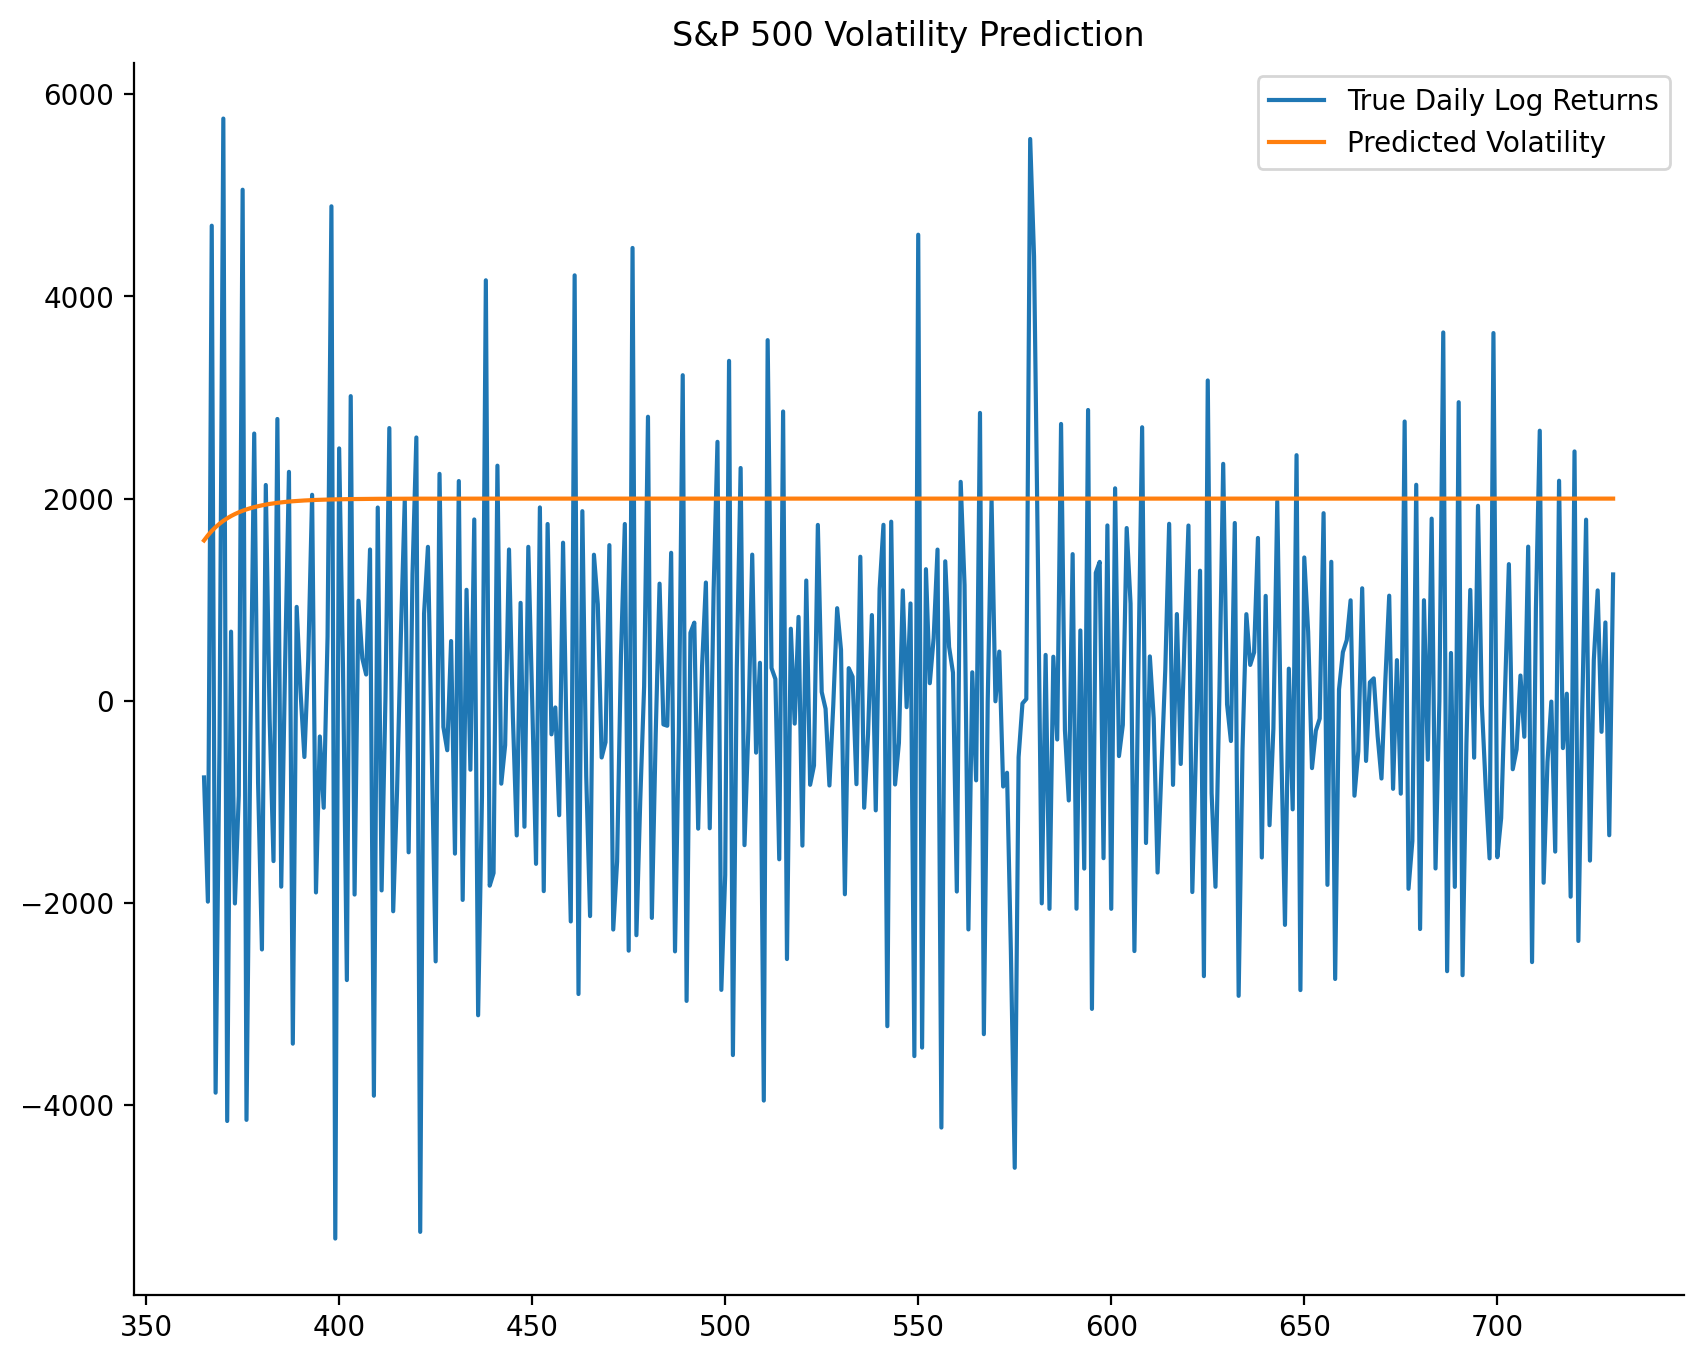

In [0]:
# n-step head forecast garch
start = 365
end = 731
garch_model = arch_model(df["energy_diff"][:start], vol="Garch", p=1, q=1)
garch_results = garch_model.fit()

yhat = res.forecast(horizon = end-start, reindex=True)
fig,ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
# Plot true daily log returns
plt.plot(df["energy_diff"][-(end-start):])
# Plot predicted volatility
plt.plot(df.index[start:end], np.sqrt(yhat.variance.values[-1, :]))
plt.title('S&P 500 Volatility Prediction')
plt.legend(['True Daily Log Returns', 'Predicted Volatility'])

In [0]:
# 1-step ahead garch
rolling_preds = []

for i in range(end-start):
    train = df[:-(end-start-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=df.index[start:end])

Text(0.5, 1.0, 'S&P 500 Rolling Volatility Prediction')

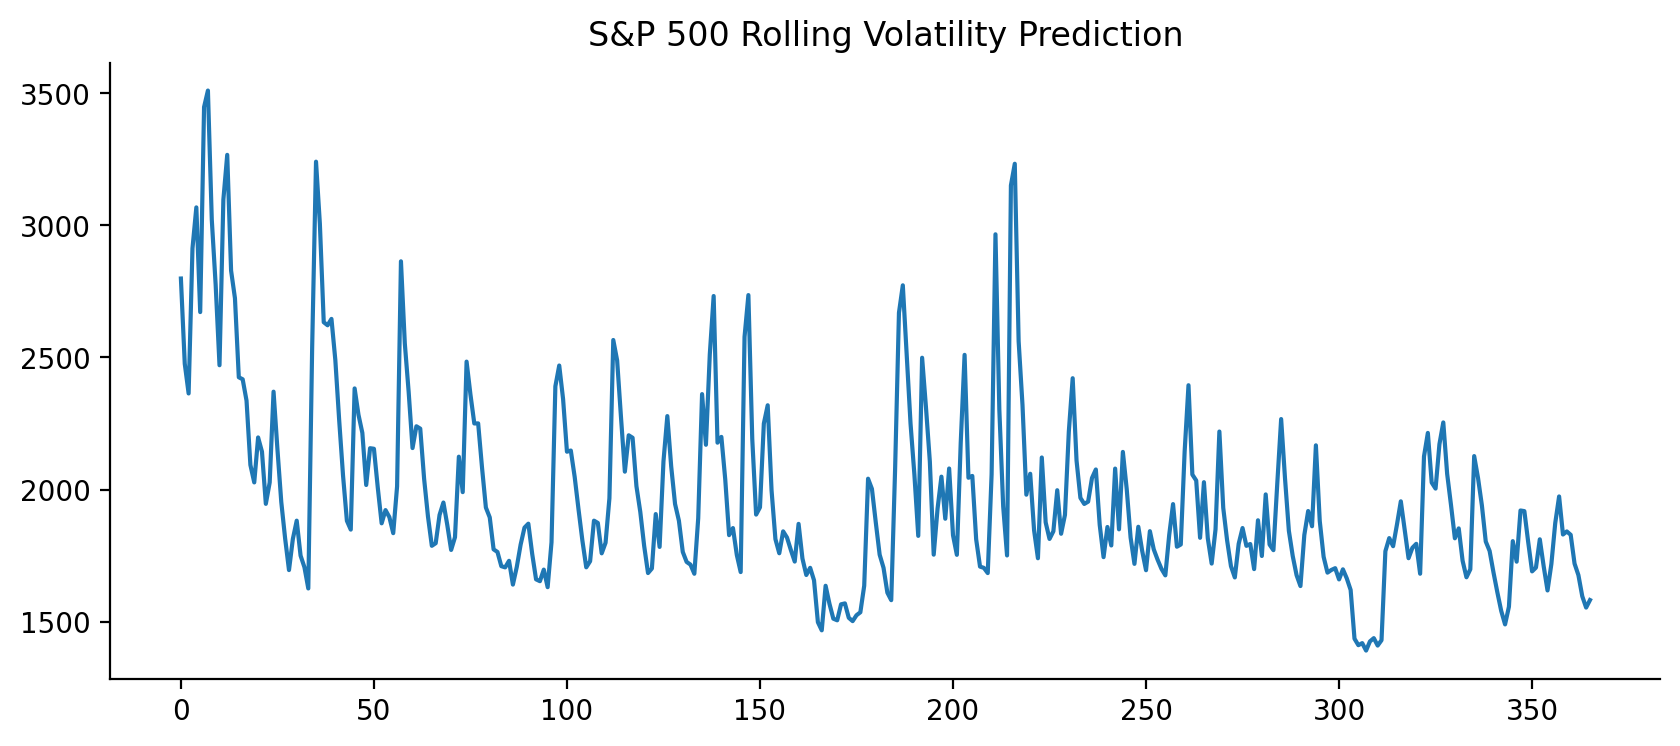

In [0]:
# Plot of predicted test data rolling volatility predictions garch
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title('S&P 500 Rolling Volatility Prediction')

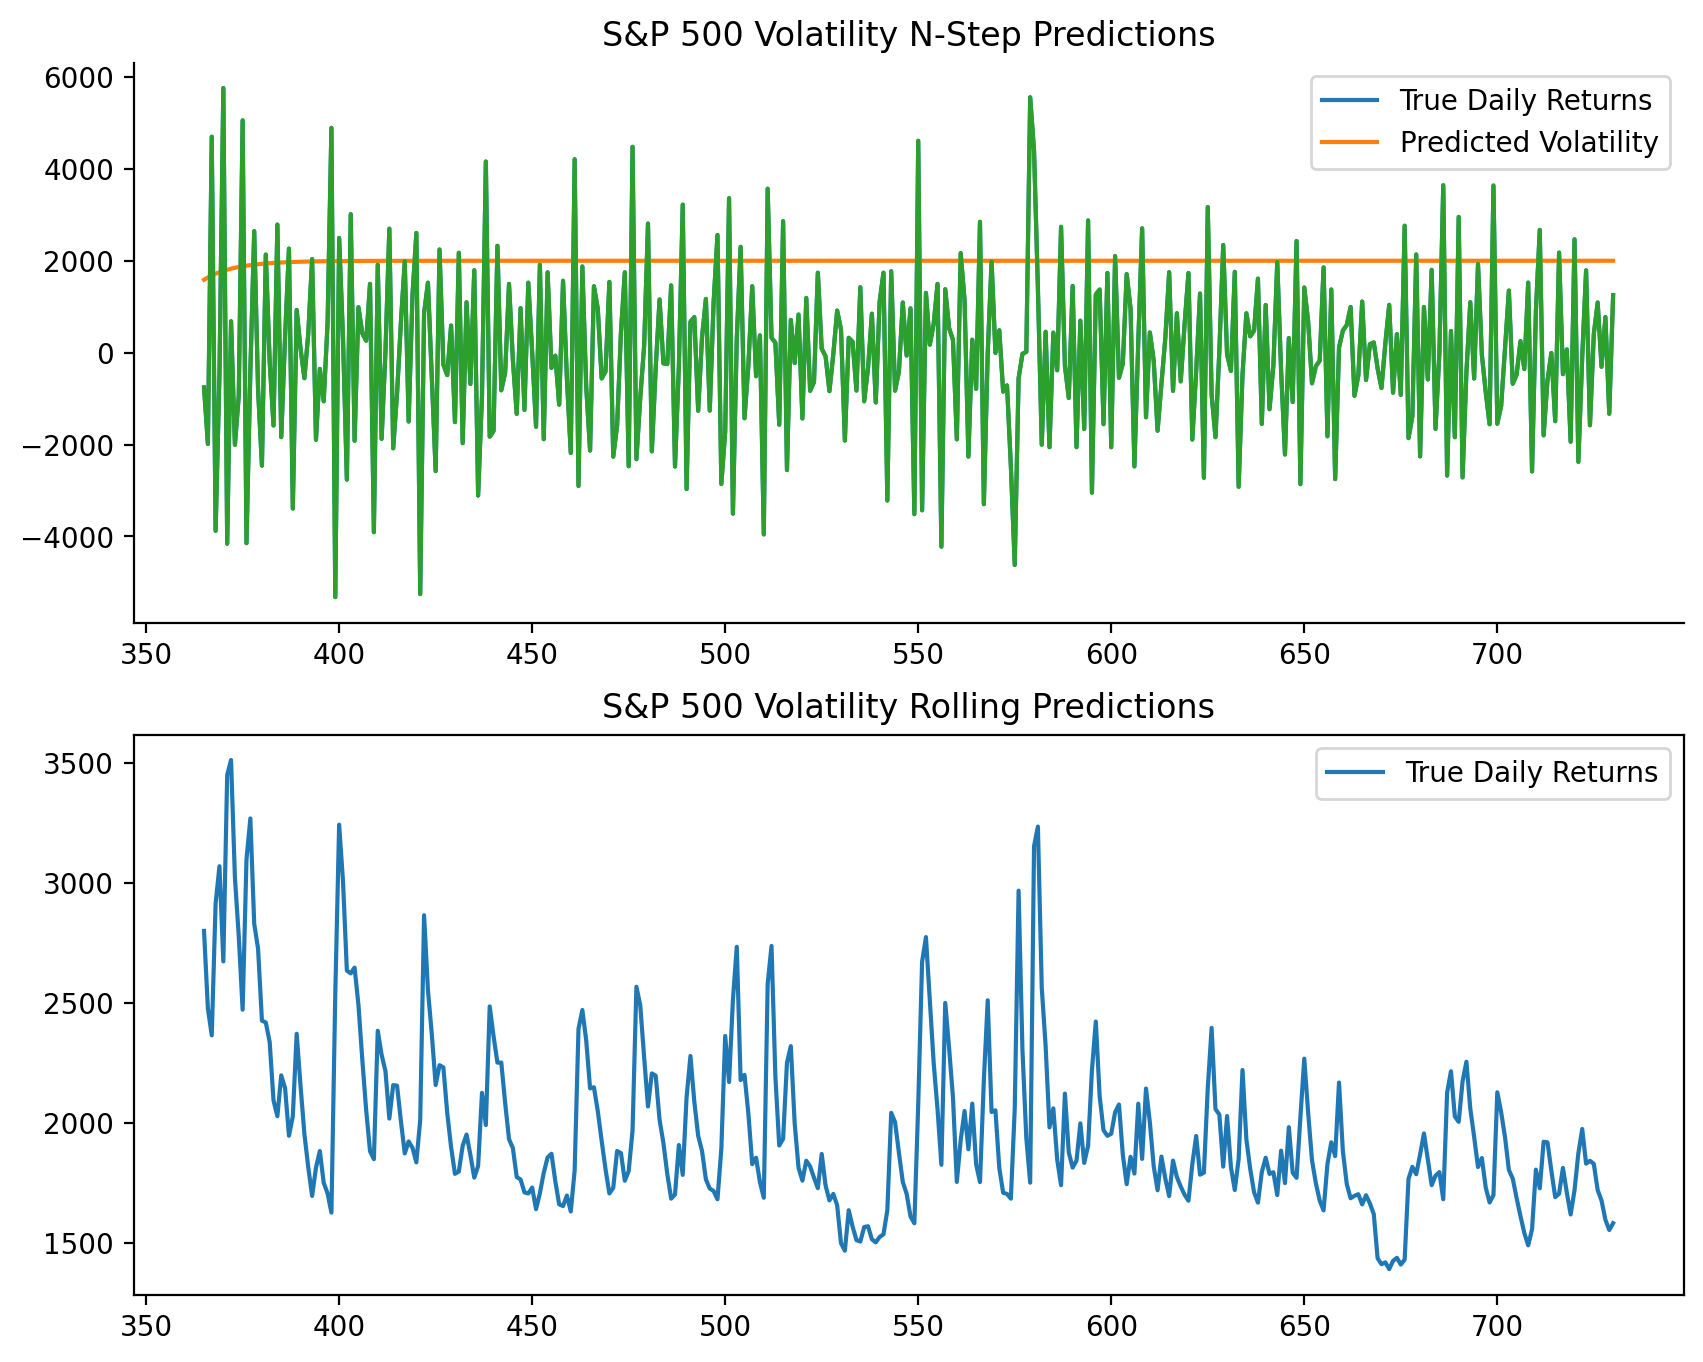

In [0]:
# Compare n-step-ahead and one-step-ahead rolling predictions garch
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.spines[['top','right']].set_visible(False)
ax1.plot(df["energy_diff"][-(end-start):])
ax1.plot(df.index[start:end], np.sqrt(yhat.variance.values[-1,:]))
ax1.set_title("S&P 500 Volatility N-Step Predictions")
ax1.legend(['True Daily Returns', 'Predicted Volatility'])

ax.spines[['top','right']].set_visible(False)
ax1.plot(df["energy_diff"][-(end-start):])
ax2.plot(df.index[start:end],rolling_preds)
ax2.set_title("S&P 500 Volatility Rolling Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rolling Volatility'])
plt.show()

#### Tests naive

In [0]:
new_df = data.query('location_id==1420066')
new_df = new_df.assign(intervention2 = lambda d: (d['date'] >= d['intervention']).astype(int),
                    days = np.arange(len(new_df)) +1,
                    intervention_day = lambda d: d['intervention2'].cumsum())
naive = smf.ols(formula = 'energy_diff ~ intervention2 + days + intervention_day', data = new_df)
res = naive.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            energy_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.09057
Date:                Tue, 19 Dec 2023   Prob (F-statistic):              0.965
Time:                        12:22:04   Log-Likelihood:                -6626.0
No. Observations:                 731   AIC:                         1.326e+04
Df Residuals:                     727   BIC:                         1.328e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          120.1990    219.929  

In [0]:
print(dg.acorr_breusch_godfrey(res, nlags=6))

(246.78051537088498, 1.9992300595428246e-50, 61.24245899174263, 2.4740496014014215e-61)


In [0]:
print(dg.het_arch(res.resid, nlags=6))

(97.5742080943385, 8.042828921864827e-19, 18.60997808175029, 3.5467447041182444e-20)


/root/.ipykernel/1169/command-3579454840576845-216934753:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


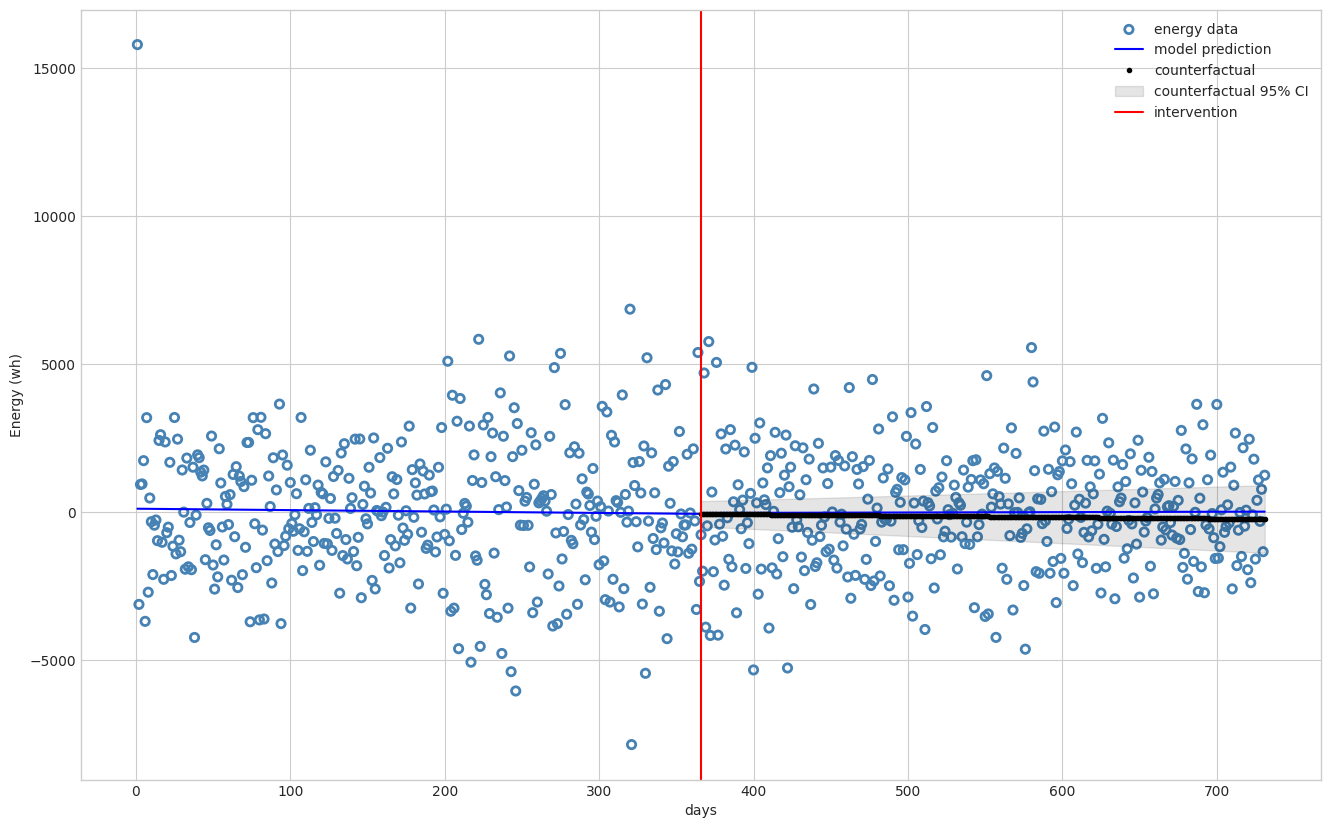

In [0]:
start = 365
end = 731
beta = res.params

# Get model predictions and 95% CI
predictions = res.get_prediction(df)
summary = predictions.summary_frame(alpha=0.05)

# Mean predictions
y_pred = predictions.predicted_mean

# counterfactual assumes no interventions
cf_data = df.copy()
cf_data['intervention2'] = 0.0
cf_data['intervention_day'] = 0.0

# counter-factual predictions
cf = res.get_prediction(cf_data).summary_frame(alpha=0.05)

# Plotting energy consumption data
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(df["days"], df["energy_diff"], facecolors='none', edgecolors='steelblue', label="energy data", linewidths=2)


# Plot model mean energy consumption prediction
ax.plot(df["days"][:start], y_pred[:start], 'b-', label="model prediction")
ax.plot(df["days"][start:], y_pred[start:], 'b-')

# Plot counterfactual mean energy consumption with 95% confidence interval
ax.plot(df["days"][start:], cf['mean'][start:], 'k.', label="counterfactual")
ax.fill_between(df["days"][start:], cf['mean_ci_lower'][start:], cf['mean_ci_upper'][start:], color='k', alpha=0.1, label="counterfactual 95% CI");

# Plot line marking intervention moment
ax.axvline(x = 366, color = 'r', label = 'intervention')

ax.legend(loc='best')
#plt.ylim([10, 15])
plt.xlabel("days")
plt.ylabel("Energy (wh)");

<Axes: ylabel='Density'>

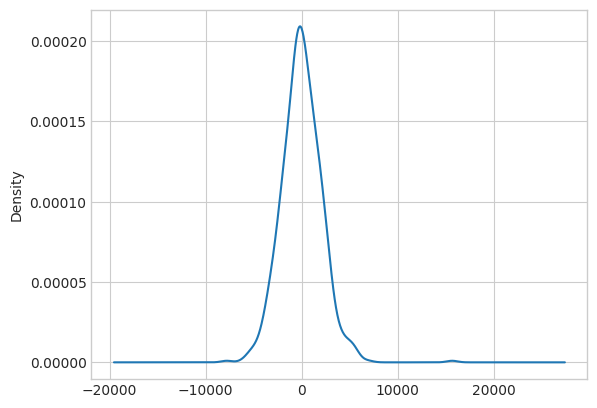

In [0]:
res.resid.plot(kind='kde')

In [0]:
rules = alt.Chart(pd.DataFrame({
  'residuals': [0.0],
  'color': ['black']
})).mark_rule().encode(
  y='residuals',
  color=alt.Color('color:N', scale=None)
)

residual_plot = alt.Chart(rules).mark_point().encode(
    x=alt.X('Weeks'),
    y=alt.Y('residuals')
)

rules + residual_plot 

alt.LayerChart(...)

#### Test ARIMA

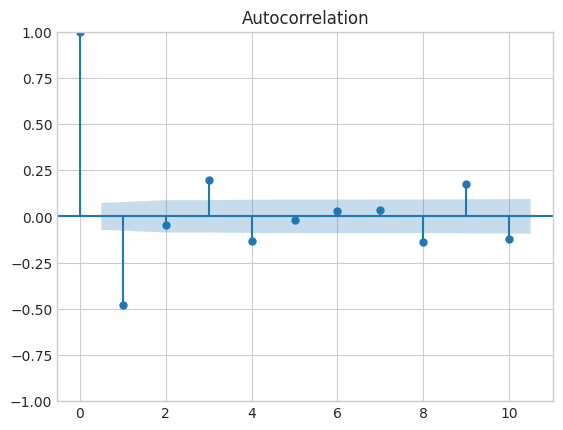

In [0]:
sm.graphics.tsa.plot_acf(res.resid, lags=10)
plt.show()

/databricks/python/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


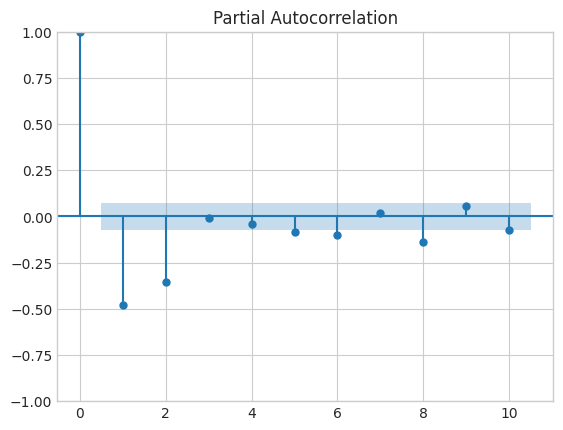

In [0]:
sm.graphics.tsa.plot_pacf(res.resid, lags=10)
plt.show() 

In [0]:
arima_results = ARIMA(df["energy_diff"], df[["intervention2","days","intervention_day"]], order=(1,0,0)).fit()
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:            energy_diff   No. Observations:                  731
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6522.523
Date:                Fri, 15 Dec 2023   AIC                          13057.045
Time:                        12:38:08   BIC                          13084.612
Sample:                             0   HQIC                         13067.680
                                - 731                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              111.7983    127.532      0.877      0.381    -138.159     361.756
intervention2       28.8803    168.254      0.172      0.864    -300.891     358.651
days                -0.4424 

/root/.ipykernel/1169/command-3579454840576853-4278199795:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


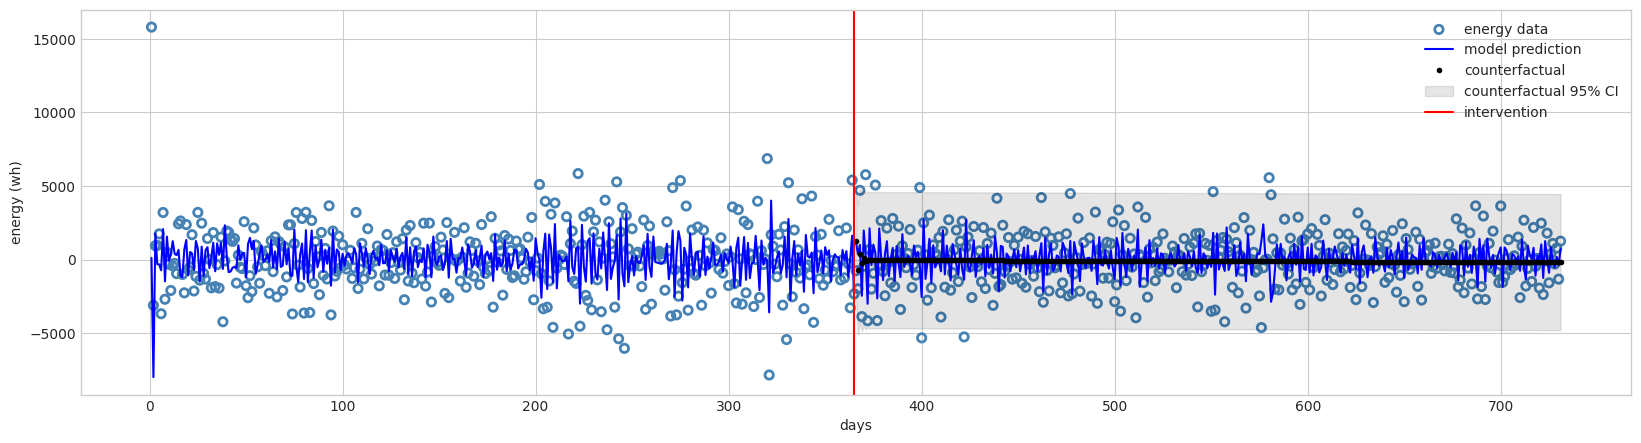

In [0]:
start = 365
end = 731

predictions = arima_results.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.05)

arima_cf = ARIMA(df["energy_diff"][:start], df["days"][:start], order=(1,0,0)).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(366, exog=df["days"][start:]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(20,5))

# Plot energy consumption data
ax.scatter(df["days"], df["energy_diff"], facecolors='none', edgecolors='steelblue', label="energy data", linewidths=2)

# Plot model mean bounce prediction
ax.plot(df["days"][:start], y_pred[:start], 'b-', label="model prediction")
ax.plot(df["days"][start:], y_pred[start:], 'b-')

# Plot counterfactual mean bounce rate with 95% confidence interval
ax.plot(df["days"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df["days"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI");


# Plot line marking intervention moment
ax.axvline(x = 365, color = 'r', label = 'intervention')

ax.legend(loc='best')
#plt.ylim([10, 15])
plt.xlabel("days")
plt.ylabel("energy (wh)");

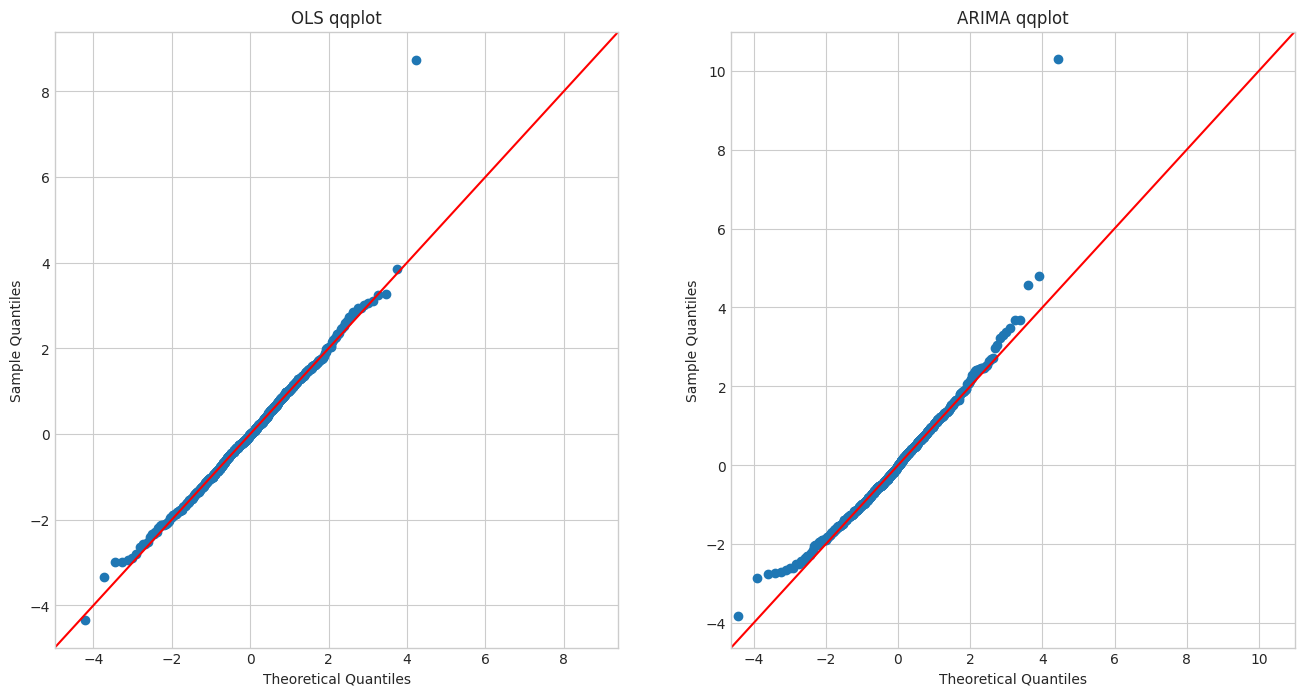

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
sm.qqplot(res.resid, sp.stats.t, fit=True, line="45", ax=ax1);
ax1.set_title("OLS qqplot");

sm.qqplot(arima_results.resid, sp.stats.t, fit=True, line="45", ax=ax2);
ax2.set_title("ARIMA qqplot");
plt.show();